# Part B:

In [1]:
!unzip -q /content/dataset.zip -d /content/dataset

In [ ]:
pip install torch torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/12/c2/7c89c62f2b0a606070aa7cdb8af8af0c905562942778ebdd77600642c3b9/torchvision-0.18.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torchvision-0.18.0-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/2a/b7/a3cf5fd40334b9785cc83ee0c96b50603026eb3aa70210a33729018e7029/torch-2.3.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.3.0-cp311-cp311-win_amd64.whl.metadata (26 kB)
  Obtaining dependency information for mkl<=2021.4.0,>=2021.1.1 from https://files.pythonhosted.org/packages/fe/1c/5f6dbf18e8b73e0a5472466f0ea8d48ce9efae39bd2ff38cebf8dce61259/mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Obtaining dependency information for intel-openmp==2021.* from https://files.pythonhosted.org/packages/6f/21/b590c0cc3888b24f2ac989

ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [2]:
#importing all required libraries
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import models
import glob
import os
import random
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
#importing torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, densenet121, vgg19
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# paths for the data sets
extracted_path = '/content/dataset/dataset'
train_path = '/content/dataset/train'
test_path = '/content/dataset/test'

# 1.	For each class, treat images from 0001 to 0040 as train and the remaining as test.

# Dataset Preparation:

In [4]:
# Create directories for training and testing sets
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)


In [5]:
# Organize the dataset
categories = os.listdir(extracted_path)

for category in categories:
    category_full_path = os.path.join(extracted_path, category)
    if not os.path.isdir(category_full_path):
        continue

    # Create category directories in train and test folders
    os.makedirs(os.path.join(train_path, category), exist_ok=True)
    os.makedirs(os.path.join(test_path, category), exist_ok=True)

    # Get all image files in the category
    images = sorted(os.listdir(category_full_path))

    # Split the images into train (0001 to 0040) and test sets
    train_images = images[:40]
    test_images = images[40:]

    # Move train images
    for image in train_images:
        src = os.path.join(category_full_path, image)
        dst = os.path.join(train_path, category, image)
        print(f"Moving {src} to {dst}")
        shutil.move(src, dst)

    # Move test images
    for image in test_images:
        src = os.path.join(category_full_path, image)
        dst = os.path.join(test_path, category, image)
        print(f"Moving {src} to {dst}")
        shutil.move(src, dst)

print("Dataset organized into training and testing sets.")


Moving /content/dataset/dataset/pizza/image_0001.jpg to /content/dataset/train/pizza/image_0001.jpg
Moving /content/dataset/dataset/pizza/image_0002.jpg to /content/dataset/train/pizza/image_0002.jpg
Moving /content/dataset/dataset/pizza/image_0003.jpg to /content/dataset/train/pizza/image_0003.jpg
Moving /content/dataset/dataset/pizza/image_0004.jpg to /content/dataset/train/pizza/image_0004.jpg
Moving /content/dataset/dataset/pizza/image_0005.jpg to /content/dataset/train/pizza/image_0005.jpg
Moving /content/dataset/dataset/pizza/image_0006.jpg to /content/dataset/train/pizza/image_0006.jpg
Moving /content/dataset/dataset/pizza/image_0007.jpg to /content/dataset/train/pizza/image_0007.jpg
Moving /content/dataset/dataset/pizza/image_0008.jpg to /content/dataset/train/pizza/image_0008.jpg
Moving /content/dataset/dataset/pizza/image_0009.jpg to /content/dataset/train/pizza/image_0009.jpg
Moving /content/dataset/dataset/pizza/image_0010.jpg to /content/dataset/train/pizza/image_0010.jpg


In [6]:
class CustomDataset:
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.files = []
        for class_idx, class_name in enumerate(self.classes):
            class_files = glob.glob(os.path.join(root_dir, class_name, '*'))
            self.files.extend([(file, class_idx) for file in class_files])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


train_dataset = CustomDataset(root_dir=train_path)
test_dataset = CustomDataset(root_dir=test_path)

# To create data loaders:


train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to 224x224 pixels
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Add transform to the dataset
train_dataset.transform = transform
test_dataset.transform = transform

# Model Loading

In [9]:
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of classes in your dataset
num_classes = 15

# Load and modify a pretrained ResNet18 model
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model_resnet.to(device)

# Load and modify a pretrained DenseNet121 model
model_densenet = models.densenet121(pretrained=True)
model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, num_classes)
model_densenet.to(device)

# Load and modify a pretrained VGG19 model
model_vgg = models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, num_classes)
model_vgg.to(device)

print("Models are defined and moved to the device successfully.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Models are defined and moved to the device successfully.


# Model Training

In [17]:
#trains the model by loading data from different datasets iterates over epoches and returns a dataframe of results with metrics
def train_model(model, train_loader, test_loader, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize lists to store metrics for DataFrame
    epochs = []
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    precisions = []
    recalls = []

    for epoch in range(num_epochs): #iterating over epoches
        model.train()
        total_train = 0
        correct_train = 0
        train_loss = 0

        # Train the model
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Evaluate the model
        model.eval()
        test_loss = 0
        total_test = 0
        correct_test = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * correct_test / total_test

        # Calculate per-class precision and recall
        precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)

        # Append results for this epoch
        epochs.append(epoch + 1)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        precisions.append(precision.tolist())  # Convert to list for DataFrame compatibility
        recalls.append(recall.tolist())

        print(f'Epoch {epoch+1}/{num_epochs} - Train Accuracy: {train_accuracy:.2f}% Test Accuracy: {test_accuracy:.2f}%')

    # Create DataFrame
    results_df = pd.DataFrame({
        'Epoch': epochs,
        'Train Loss': train_losses,
        'Test Loss': test_losses,
        'Train Accuracy': train_accuracies,
        'Test Accuracy': test_accuracies,
        'Precision per Class': precisions,
        'Recall per Class': recalls
    })

    return model, results_df

Train the models

In [11]:
model_resnets = train_model(model_resnet, train_loader, test_loader, num_epochs = 10) #resnetmodel_train

Epoch 1/10 - Train Accuracy: 73.33% Test Accuracy: 57.56%
Epoch 2/10 - Train Accuracy: 87.83% Test Accuracy: 56.10%
Epoch 3/10 - Train Accuracy: 89.83% Test Accuracy: 74.63%
Epoch 4/10 - Train Accuracy: 95.50% Test Accuracy: 87.80%
Epoch 5/10 - Train Accuracy: 96.17% Test Accuracy: 83.41%
Epoch 6/10 - Train Accuracy: 98.50% Test Accuracy: 84.88%
Epoch 7/10 - Train Accuracy: 99.17% Test Accuracy: 91.22%
Epoch 8/10 - Train Accuracy: 99.00% Test Accuracy: 82.44%
Epoch 9/10 - Train Accuracy: 99.17% Test Accuracy: 92.68%
Epoch 10/10 - Train Accuracy: 99.00% Test Accuracy: 83.41%


In [12]:
#model summary
model_resnets[0]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
model_resnets[1]

Epoch  Train Loss  Test Loss  Train Accuracy  Test Accuracy  \
0      1    0.871395   2.122496       73.333333      57.560976   
1      2    0.414668   2.449719       87.833333      56.097561   
2      3    0.344703   0.944258       89.833333      74.634146   
3      4    0.166526   0.439759       95.500000      87.804878   
4      5    0.118078   0.506572       96.166667      83.414634   
5      6    0.052136   0.451930       98.500000      84.878049   
6      7    0.043378   0.293822       99.166667      91.219512   
7      8    0.039173   0.515182       99.000000      82.439024   
8      9    0.043312   0.230930       99.166667      92.682927   
9     10    0.048764   0.530645       99.000000      83.414634   

                                 Precision per Class  \
0  [0.75, 1.0, 0.0, 0.5625, 0.7, 1.0, 0.407407407...   
1  [1.0, 0.5, 1.0, 0.5, 0.4827586206896552, 0.625...   
2  [0.8, 1.0, 0.7692307692307693, 0.8333333333333...   
3  [0.8333333333333334, 0.875, 0.8666666666666667...   
4  [0.7857142857142857, 1.0, 0.8, 0.8888888888888...   
5  [0.7647058823529411, 0.42105263157894735, 1.0,...   
6  [0.9285714285714286, 0.5384615384615384, 0.933...   
7  [0.48148148148148145, 0.8181818181818182, 1.0,...   
8  [1.0, 0.8571428571428571, 0.75, 1.0, 0.875, 1....   
9  [1.0, 0.2916666666666667, 0.875, 0.9, 0.923076...   

                                    Recall per Class  
0  [0.9230769230769231, 0.09090909090909091, 0.0,...  
1  [0.15384615384615385, 0.45454545454545453, 0.2...  
2  [0.9230769230769231, 0.5454545454545454, 0.588...  
3  [0.7692307692307693, 0.6363636363636364, 0.764...  
4  [0.8461538461538461, 0.18181818181818182, 0.70...  
5  [1.0, 0.7272727272727273, 0.8235294117647058, ...  
6  [1.0, 0.6363636363636364, 0.8235294117647058, ...  
7  [1.0, 0.8181818181818182, 0.5294117647058824, ...  
8  [0.9230769230769231, 0.5454545454545454, 0.882...  
9  [0.7692307692307693, 0.6363636363636364, 0.823...

from matplotlib import pyplot as plt
results_resnet['Epoch'].plot(kind='hist', bins=20, title='Epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_resnet['Train Loss'].plot(kind='hist', bins=20, title='Train Loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_resnet['Test Loss'].plot(kind='hist', bins=20, title='Test Loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_resnet['Train Accuracy'].plot(kind='hist', bins=20, title='Train Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_resnet.plot(kind='scatter', x='Epoch', y='Train Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_resnet.plot(kind='scatter', x='Train Loss', y='Test Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_resnet.plot(kind='scatter', x='Test Loss', y='Train Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_resnet.plot(kind='scatter', x='Train Accuracy', y='Test Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epoch']
  ys = series['Train Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_resnet.sort_values('Epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epoch')
_ = plt.ylabel('Train Loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epoch']
  ys = series['Test Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_resnet.sort_values('Epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epoch')
_ = plt.ylabel('Test Loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epoch']
  ys = series['Train Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_resnet.sort_values('Epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epoch')
_ = plt.ylabel('Train Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epoch']
  ys = series['Test Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_resnet.sort_values('Epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epoch')
_ = plt.ylabel('Test Accuracy')

from matplotlib import pyplot as plt
results_resnet['Epoch'].plot(kind='line', figsize=(8, 4), title='Epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_resnet['Train Loss'].plot(kind='line', figsize=(8, 4), title='Train Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_resnet['Test Loss'].plot(kind='line', figsize=(8, 4), title='Test Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_resnet['Train Accuracy'].plot(kind='line', figsize=(8, 4), title='Train Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

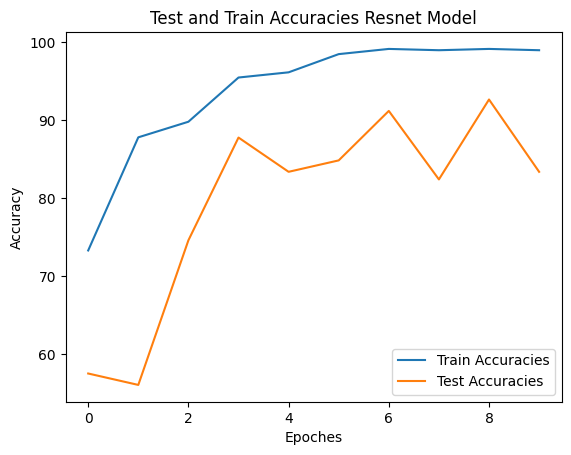

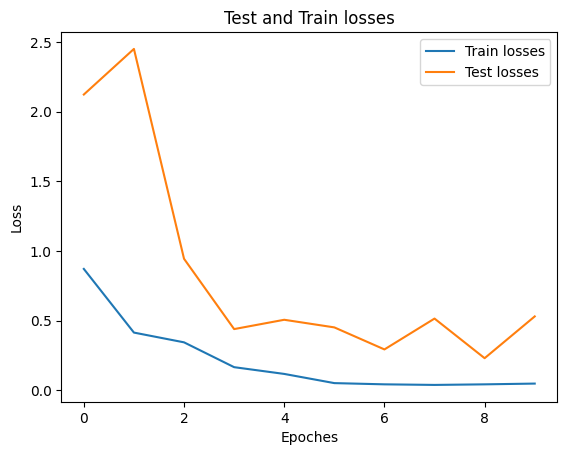

In [14]:
#plotting the accuracies and losses of the resnet model
import matplotlib.pyplot as plt
results_resnet =  model_resnets[1]
plt.plot(results_resnet['Train Accuracy'], label = 'Train Accuracies')
plt.plot(results_resnet['Test Accuracy'],label = 'Test Accuracies')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test and Train Accuracies Resnet Model')
plt.show()

plt.plot(results_resnet['Train Loss'], label = 'Train losses')
plt.plot(results_resnet['Test Loss'],label = 'Test losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.title('Test and Train losses')
plt.show()

Inference:

•	On training over 10 epochs, the ResNet18 model shows an increase in training accuracy, from 72.67% to 98.17%.

•	Test accuracy also shows an increase, from 57% to 99%. Train losses gradually decrease, while test losses also decrease with certain variables.

•	Each class's precision and recall parameters reflect model performance variations across classes.

•	By the final epoch, both metrics improve significantly for most classes, indicating an increase in model robustness and generalizability.

Most classes had high precision and recall, indicating reliable model
performance overall. However, classes 3, 4, and 13 showed more variability and lower metrics, suggesting the model had difficulty consistently identifying these classes. Further data or fine-tuning could help improve performance in these challenging areas.



In [19]:
model_vggs = train_model(model_vgg, train_loader, test_loader, num_epochs = 25) #vgg models training

Epoch 1/25 - Train Accuracy: 81.83% Test Accuracy: 42.93%
Epoch 2/25 - Train Accuracy: 88.50% Test Accuracy: 40.98%
Epoch 3/25 - Train Accuracy: 92.00% Test Accuracy: 48.29%
Epoch 4/25 - Train Accuracy: 86.33% Test Accuracy: 40.98%
Epoch 5/25 - Train Accuracy: 83.83% Test Accuracy: 44.39%
Epoch 6/25 - Train Accuracy: 89.50% Test Accuracy: 42.93%
Epoch 7/25 - Train Accuracy: 93.83% Test Accuracy: 38.05%
Epoch 8/25 - Train Accuracy: 89.33% Test Accuracy: 44.39%
Epoch 9/25 - Train Accuracy: 90.50% Test Accuracy: 44.88%
Epoch 10/25 - Train Accuracy: 93.50% Test Accuracy: 45.85%
Epoch 11/25 - Train Accuracy: 95.17% Test Accuracy: 43.41%
Epoch 12/25 - Train Accuracy: 94.83% Test Accuracy: 47.32%
Epoch 13/25 - Train Accuracy: 92.17% Test Accuracy: 46.34%
Epoch 14/25 - Train Accuracy: 90.67% Test Accuracy: 44.39%
Epoch 15/25 - Train Accuracy: 92.83% Test Accuracy: 43.41%
Epoch 16/25 - Train Accuracy: 91.33% Test Accuracy: 44.88%
Epoch 17/25 - Train Accuracy: 93.50% Test Accuracy: 42.44%
Epoch 

In [21]:
model_vggs[1]

Epoch  Train Loss  Test Loss  Train Accuracy  Test Accuracy  \
0       1    0.559572   3.334271       81.833333      42.926829   
1       2    0.281496   4.673200       88.500000      40.975610   
2       3    0.225525   3.896040       92.000000      48.292683   
3       4    0.440763   4.038773       86.333333      40.975610   
4       5    0.513456   3.006685       83.833333      44.390244   
5       6    0.339853   3.318837       89.500000      42.926829   
6       7    0.209369   4.993302       93.833333      38.048780   
7       8    0.319674   4.149764       89.333333      44.390244   
8       9    0.311550   4.185902       90.500000      44.878049   
9      10    0.186479   3.954192       93.500000      45.853659   
10     11    0.181460   3.230295       95.166667      43.414634   
11     12    0.155187   4.299117       94.833333      47.317073   
12     13    0.231536   3.213292       92.166667      46.341463   
13     14    0.373266   3.289921       90.666667      44.390244   
14     15    0.247342   3.492916       92.833333      43.414634   
15     16    0.348323   2.855069       91.333333      44.878049   
16     17    0.258200   3.814240       93.500000      42.439024   
17     18    0.275773   3.266239       91.833333      48.780488   
18     19    0.203672   4.137533       94.333333      46.829268   
19     20    0.284484   2.801116       93.333333      45.853659   
20     21    0.235236   3.962973       94.166667      44.390244   
21     22    0.184117   4.256467       93.500000      47.804878   
22     23    0.192249   3.675611       94.000000      45.853659   
23     24    0.150757   4.004685       95.500000      47.804878   
24     25    0.297361   2.660537       93.000000      45.853659   

                                  Precision per Class  \
0   [0.42857142857142855, 0.38461538461538464, 0.3...   
1   [0.3888888888888889, 0.4, 0.2727272727272727, ...   
2   [0.6666666666666666, 0.25, 0.21052631578947367...   
3   [0.75, 0.3076923076923077, 0.36363636363636365...   
4   [0.45454545454545453, 0.375, 0.6, 0.1, 0.42857...   
5   [0.46153846153846156, 0.45454545454545453, 0.3...   
6   [0.3333333333333333, 0.375, 0.3636363636363636...   
7   [0.35, 0.2727272727272727, 0.75, 0.4, 0.217391...   
8   [0.6666666666666666, 0.625, 0.25, 0.1111111111...   
9   [0.5, 0.4444444444444444, 0.19047619047619047,...   
10  [0.4, 0.4, 0.6666666666666666, 0.1538461538461...   
11  [0.35714285714285715, 0.375, 0.666666666666666...   
12  [0.5, 0.3333333333333333, 0.29411764705882354,...   
13  [0.35294117647058826, 0.5, 0.5555555555555556,...   
14  [0.375, 0.2, 0.375, 0.42857142857142855, 0.166...   
15  [0.4375, 0.36363636363636365, 0.25, 0.2, 0.153...   
16  [0.4375, 0.2857142857142857, 0.833333333333333...   
17  [0.4117647058823529, 0.375, 0.6666666666666666...   
18  [0.5384615384615384, 0.3076923076923077, 0.416...   
19  [0.4375, 0.5, 0.38461538461538464, 0.153846153...   
20  [0.4166666666666667, 0.5, 0.42857142857142855,...   
21  [0.6666666666666666, 0.3, 0.5, 0.1818181818181...   
22  [0.4, 0.4, 0.3333333333333333, 0.25, 0.4, 0.7,...   
23  [0.2857142857142857, 0.5555555555555556, 0.444...   
24  [0.8, 0.6666666666666666, 0.4117647058823529, ...   

                                     Recall per Class  
0   [0.23076923076923078, 0.45454545454545453, 0.3...  
1   [0.5384615384615384, 0.36363636363636365, 0.17...  
2   [0.6153846153846154, 0.18181818181818182, 0.23...  
3   [0.46153846153846156, 0.36363636363636365, 0.2...  
4   [0.38461538461538464, 0.2727272727272727, 0.35...  
5   [0.46153846153846156, 0.45454545454545453, 0.1...  
6   [0.5384615384615384, 0.2727272727272727, 0.235...  
7   [0.5384615384615384, 0.2727272727272727, 0.176...  
8   [0.3076923076923077, 0.45454545454545453, 0.29...  
9   [0.5384615384615384, 0.36363636363636365, 0.23...  
10  [0.46153846153846156, 0.36363636363636365, 0.2...  
11  [0.38461538461538464, 0.2727272727272727, 0.11...  
12  [0.38461538461538464, 0.45454545454545453, 0.2

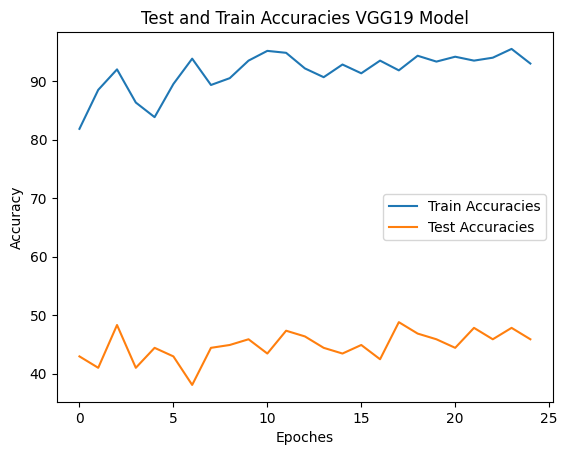

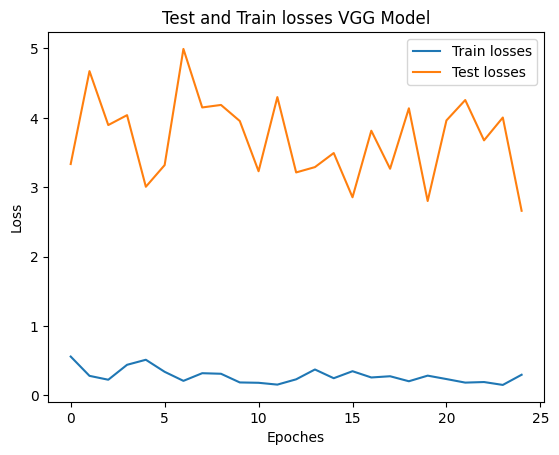

In [20]:
#plotting the accuracies and losses of the resnet model
import matplotlib.pyplot as plt
results_vggs =  model_vggs[1]
plt.plot(results_vggs['Train Accuracy'], label = 'Train Accuracies')
plt.plot(results_vggs['Test Accuracy'],label = 'Test Accuracies')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test and Train Accuracies VGG19 Model')
plt.show()

plt.plot(results_vggs['Train Loss'], label = 'Train losses')
plt.plot(results_vggs['Test Loss'],label = 'Test losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.title('Test and Train losses VGG Model')
plt.show()

Inference:

The VGG model shows gradual improvement in both train and test accuracy over the epochs. Train accuracy increase from 81% to 93%. Test accuracy increases from 42.83% to 45.00%. We can clearly see that the vgg19 model is not working well on test data as its test accuracy is not increasing. So it requires be fine tuned inorder to increase the model perfomance on this dataset.


In [ ]:
model_densenet.to(device)
# Load the saved state dictionary for DenseNet121
model_densenets= model_densenet.load_state_dict(torch.load('densenets_trained_model.pth'))

In [23]:
model_densenets = train_model(model_densenet, train_loader, test_loader, num_epochs = 10)  #densenet model train

Epoch 1/10 - Train Accuracy: 80.33% Test Accuracy: 84.39%
Epoch 2/10 - Train Accuracy: 92.83% Test Accuracy: 79.51%
Epoch 3/10 - Train Accuracy: 91.00% Test Accuracy: 69.76%
Epoch 4/10 - Train Accuracy: 94.33% Test Accuracy: 76.10%
Epoch 5/10 - Train Accuracy: 94.00% Test Accuracy: 60.98%
Epoch 6/10 - Train Accuracy: 94.00% Test Accuracy: 89.76%
Epoch 7/10 - Train Accuracy: 97.00% Test Accuracy: 88.29%
Epoch 8/10 - Train Accuracy: 98.17% Test Accuracy: 89.27%
Epoch 9/10 - Train Accuracy: 98.67% Test Accuracy: 88.78%
Epoch 10/10 - Train Accuracy: 98.83% Test Accuracy: 90.73%


In [24]:
model_densenets[1]

Epoch  Train Loss  Test Loss  Train Accuracy  Test Accuracy  \
0      1    0.751703   0.612830       80.333333      84.390244   
1      2    0.263664   0.682045       92.833333      79.512195   
2      3    0.289029   1.096539       91.000000      69.756098   
3      4    0.189534   0.784605       94.333333      76.097561   
4      5    0.212140   2.375297       94.000000      60.975610   
5      6    0.208306   0.277611       94.000000      89.756098   
6      7    0.090528   0.420483       97.000000      88.292683   
7      8    0.053959   0.287070       98.166667      89.268293   
8      9    0.049515   0.324239       98.666667      88.780488   
9     10    0.036631   0.278775       98.833333      90.731707   

                                 Precision per Class  \
0  [0.5652173913043478, 0.5555555555555556, 0.857...   
1  [0.6875, 0.7142857142857143, 1.0, 0.7857142857...   
2  [1.0, 0.75, 0.8571428571428571, 0.189655172413...   
3  [0.6842105263157895, 0.5263157894736842, 1.0, ...   
4  [1.0, 0.8333333333333334, 0.5882352941176471, ...   
5  [1.0, 0.8, 0.8571428571428571, 1.0, 0.875, 0.9...   
6  [0.8125, 0.7777777777777778, 1.0, 1.0, 0.77777...   
7  [0.75, 1.0, 0.8125, 1.0, 0.8666666666666667, 1...   
8  [0.7857142857142857, 0.6, 0.7272727272727273, ...   
9  [0.8, 0.5882352941176471, 0.75, 1.0, 1.0, 0.93...   

                                    Recall per Class  
0  [1.0, 0.9090909090909091, 0.35294117647058826,...  
1  [0.8461538461538461, 0.9090909090909091, 0.411...  
2  [0.6923076923076923, 0.2727272727272727, 0.705...  
3  [1.0, 0.9090909090909091, 0.47058823529411764,...  
4  [0.7692307692307693, 0.45454545454545453, 0.58...  
5  [0.9230769230769231, 0.7272727272727273, 0.705...  
6  [1.0, 0.6363636363636364, 0.5882352941176471, ...  
7  [0.9230769230769231, 0.7272727272727273, 0.764...  
8  [0.8461538461538461, 0.8181818181818182, 0.941...  
9  [0.9230769230769231, 0.9090909090909091, 0.882...

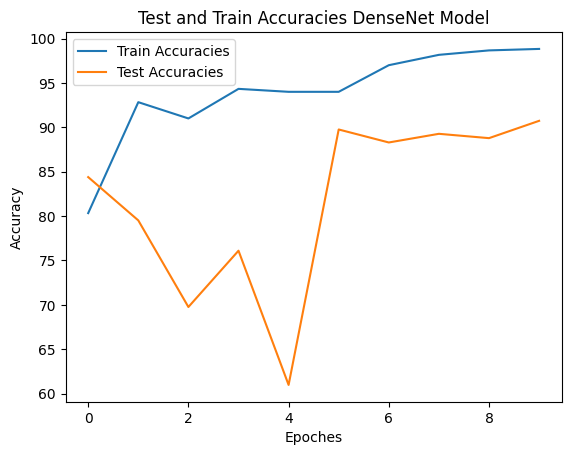

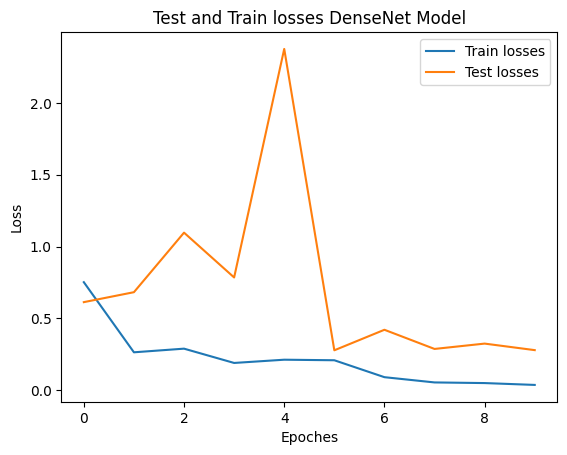

In [25]:
#plotting the accuracies and losses of the resnet model
import matplotlib.pyplot as plt
results_densnets =  model_densenets[1]
plt.plot(results_densnets['Train Accuracy'], label = 'Train Accuracies')
plt.plot(results_densnets['Test Accuracy'],label = 'Test Accuracies')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test and Train Accuracies DenseNet Model')
plt.show()

plt.plot(results_densnets['Train Loss'], label = 'Train losses')
plt.plot(results_densnets['Test Loss'],label = 'Test losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.title('Test and Train losses DenseNet Model')
plt.show()

DenseNet Inference:

•	On training over 10 epochs, the model exhibits a steady improvement as training accuracy increases from 80.17% to 99%.

•	Test accuracy follows a similar trend, improving from 84.73% to a maximum of 90.20%. However, the experimental loss is variable, increasing mainly at time 8 before consolidation.

We can also observe the test accuracy dopped suddenly and increase after 4 epoch. Same with the losses. The test loss and test accuracy is lower than train loss and test loss this suggests model is not overfitting.

Most classes exhibited high precision and recall throughout the epochs, indicating reliable model performance. However, some classes showed variability, especially in the earlier epochs, suggesting occasional challenges in consistent identification. By the final epoch, precision and recall stabilized, demonstrating improved consistency and robustness in classification.


# Model Evaluation On Test images

In [26]:
#code to visualise the images tested
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

def predict_single_image(model, image_path, class_names):
    model.eval()
    image = preprocess_image(image_path)
    image = image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_index = predicted.item()
        predicted_label = class_names[predicted_index]

    return predicted_label

def visualize_predictions(model, test_dir, num_images=6):
    # Read class names directly from the directory structure
    class_dirs = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
    class_names = sorted(class_dirs)  # Ensure class names are sorted alphabetically

    # Get a list of all images in the test directory
    all_images = []
    for class_dir in class_dirs:
        class_path = os.path.join(test_dir, class_dir)
        images = os.listdir(class_path)
        for img in images:
            all_images.append((os.path.join(class_path, img), class_dir))

    # Randomly select a few images
    selected_images = random.sample(all_images, num_images)

    plt.figure(figsize=(15, 10))
    for i, (img_path, actual_label) in enumerate(selected_images):
        predicted_label = predict_single_image(model, img_path, class_names)

        plt.subplot(2, 3, i + 1)
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Evaluation on Denset121 Model

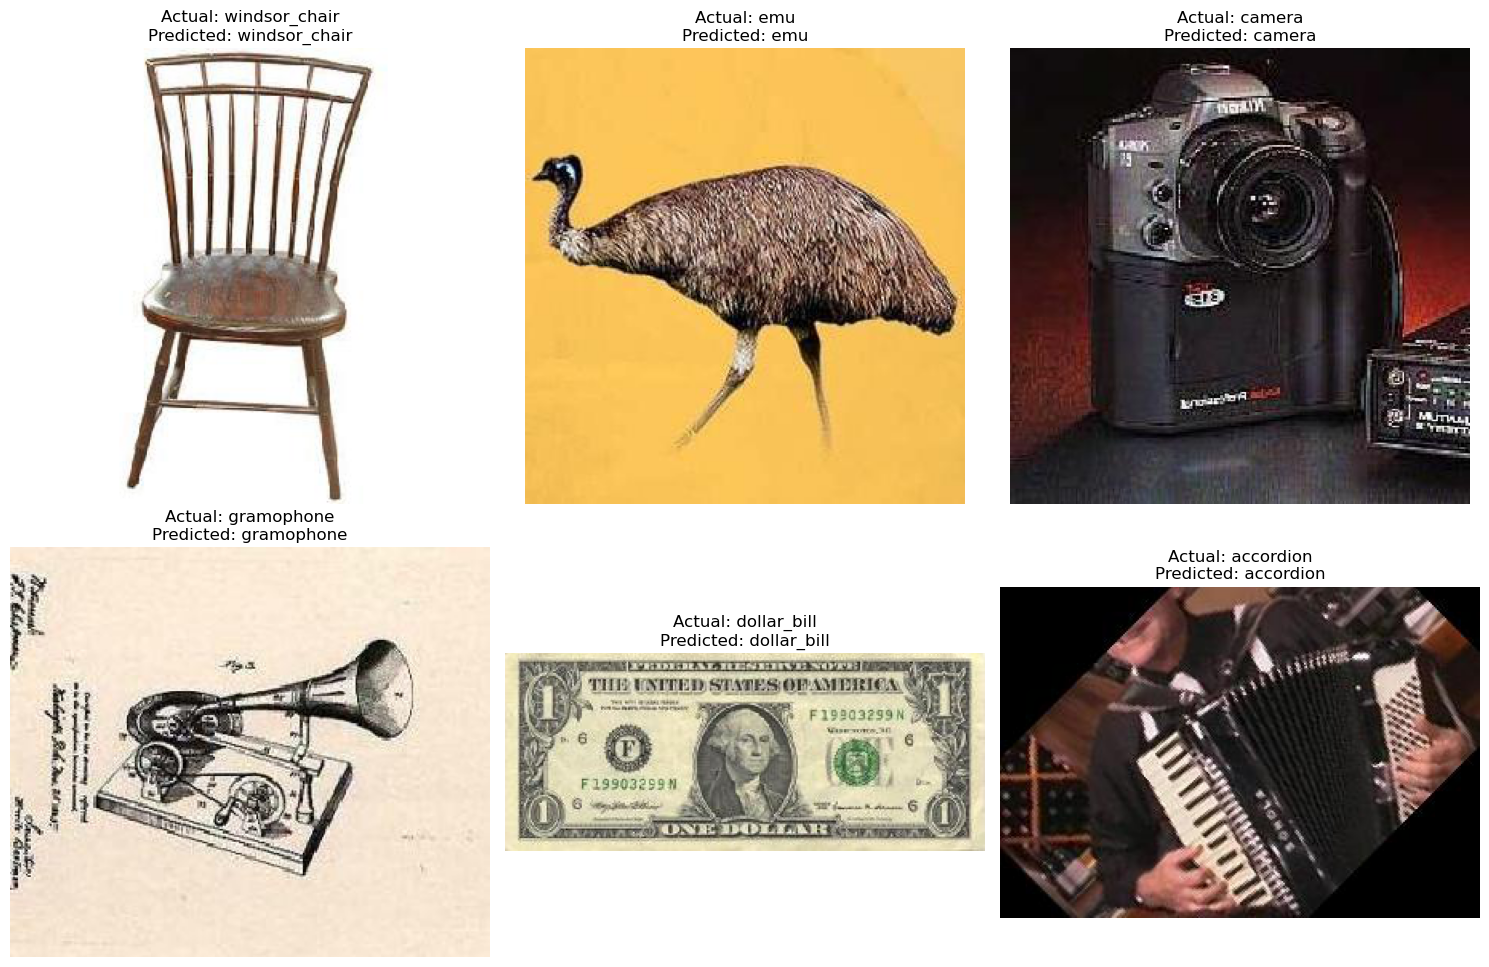

In [ ]:
visualize_predictions(model_densenets[0], r'C:\Users\Admin\Downloads\dataset1\test', num_images=6)


6/6 Images are correctly predicted

# VGG19 Evaluation

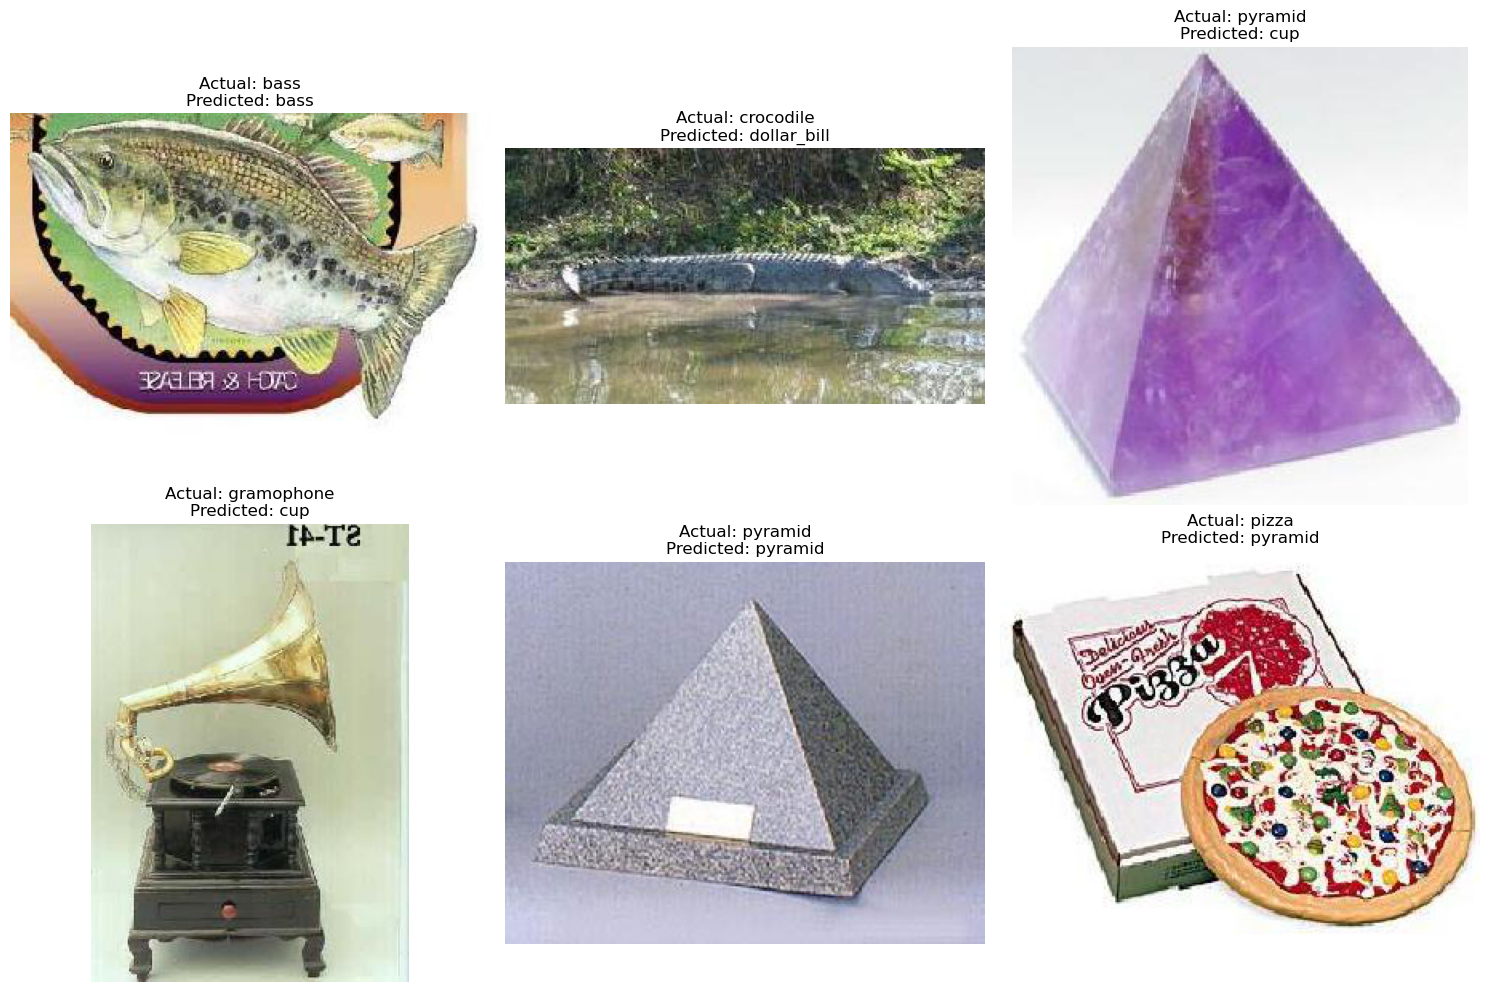

In [ ]:
visualize_predictions(model_vggs[0], test_dir, class_names, num_images=6)


2/6 Images are correctly predicted

Saving models to reuse and avoid retraining

In [31]:
torch.save(model_resnets[0].state_dict(), 'trained_resnet_model.pth')
torch.save(model_vggs[0].state_dict(),'vggs_trained_model.pth')
torch.save(model_densenets[0].state_dict(),'densenets_trained_model.pth')